In [2]:
!pip install pandas
!pip install openpyxl
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install mlxtend
!pip install scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage,dendrogram

#1.cargamos nuestra Database

In [3]:
# Cargamos el dataset con el delimitador correcto
wine_data = pd.read_csv('wine_alcohol.csv', delimiter = ';')

# Mostramos las primeras filas del dataset y resumen de datos
wine_data.head()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,5,1,9.8
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,5,1,9.8
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,6,1,9.8
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4


nosn deshacemos de lo innecesario para aplicar nuestro algoritmo (Kmeans)

In [4]:
# Eliminamos la columna 'id' que no es necesaria para el análisis
wine_data.drop('id', axis = 1, inplace = True)

print(wine_data.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'quality', 'wine type', 'alcohol'],
      dtype='object')


In [5]:
# Seleccionamos las características relevantes para el análisis de agrupamiento (excluimos la columna 'quality')
X = wine_data.drop('quality', axis = 1)

In [6]:
# Estandarizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Sección del mejor k por silueta y método del codo

El método evalúa la cohesión y la separación de los clusters. Un valor alto de la puntuación de silueta (cercano a 1) indica que los puntos de datos están bien agrupados dentro de sus clusters y están separados de otros clusters.
Por otro lado el método del codo se basa en ver cuando empieza a estabilizarse llegado a un número de  K que sus siguientes mantegan dicho valor o cercano.

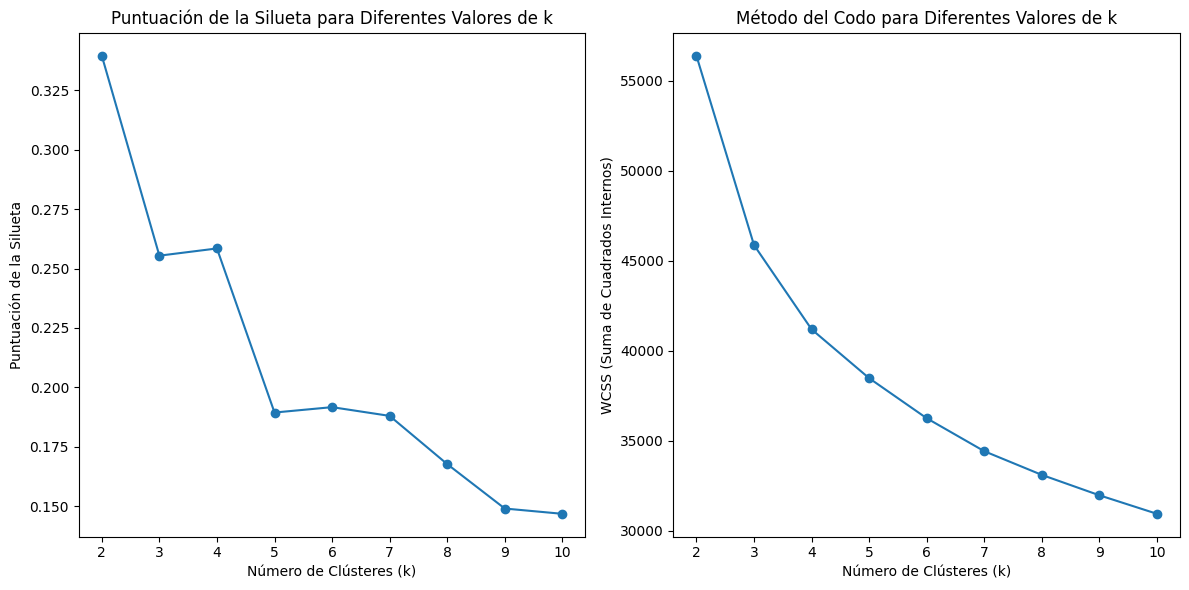

In [7]:
# Inicializamos la lista para almacenar las puntuaciones
silhouette_scores = []
wcss = []
 #Probamos diferentes valores de k para el algoritmo K-Means
for k in range(2, 11):

     #Aplicamos el algoritmo K-Means
     kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 42)
     kmeans.fit(X_scaled)

     #Calculamos la puntuación de la silueta
     silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
     silhouette_scores.append(silhouette_avg)

     # Calculamos WCSS para el método del codo
     wcss.append(kmeans.inertia_)


# Pintamos una gráfica de la puntuación de la silueta para diferentes valores de k
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Puntuación de la Silueta')
plt.title('Puntuación de la Silueta para Diferentes Valores de k')

# Pintamos una gráfica del método del codo para diferentes valores de k
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('WCSS (Suma de Cuadrados Internos)')
plt.title('Método del Codo para Diferentes Valores de k')

plt.tight_layout()
plt.show()






Como vemos en silueta, el mejor valor de k sería k=2, mientras que oberservamos que en el método del codo podriamos optar por un k=3 0 k=5 dependiendo de nuestra interpretación ya que no se visualiza muy claro con neste método

# 3. Ahora comparamos respecto a los diferentes tipos de K
  ## K según silueta

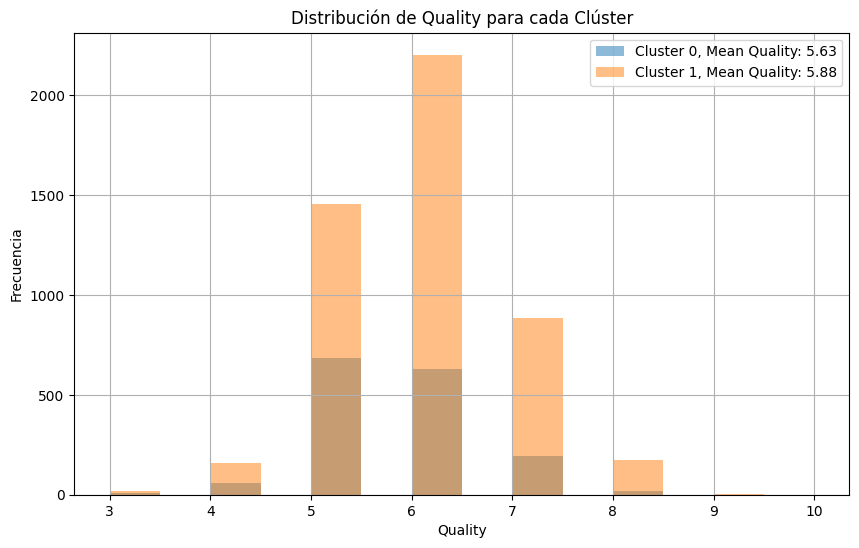

In [8]:
# Aplicamos el algoritmo K-Means con el mejor valor de k
best_k = 2  # El mejor valor de k obtenido
kmeans = KMeans(n_clusters = best_k, n_init = 10, random_state = 42)
kmeans.fit(X_scaled)
# Agregamos las etiquetas de clúster al DataFrame original
wine_data['cluster'] = kmeans.labels_
# Calculamos la media de calidad por clúster
quality_means = wine_data.groupby('cluster')['quality'].mean()
# Pintamos la distribución de la calidad por clúster
plt.figure(figsize = (10, 6))

for cluster, quality_mean in quality_means.items():
    cluster_data = wine_data[wine_data['cluster'] == cluster]
    plt.hist(cluster_data['quality'], bins = np.arange(3, 10.5, 0.5), alpha = 0.5, label = f'Cluster {cluster}, Mean Quality: {quality_mean:.2f}')
plt.xlabel('Quality')
plt.ylabel('Frecuencia')
plt.title('Distribución de Quality para cada Clúster')
plt.legend()
plt.grid(True)
plt.show()

ANOVA p-value: 1.96803280951277e-24
Centroides de los clústeres:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.858862          1.163707    -0.333185       -0.603688   0.917303   
1      -0.279919         -0.379273     0.108591        0.196753  -0.298966   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.833537             -1.227853  0.700306  0.574722   0.862261   
1             0.271665              0.400180 -0.228243 -0.187312  -0.281027   

   wine type   alcohol  
0  -1.732745 -0.065659  
1   0.564734  0.021400  


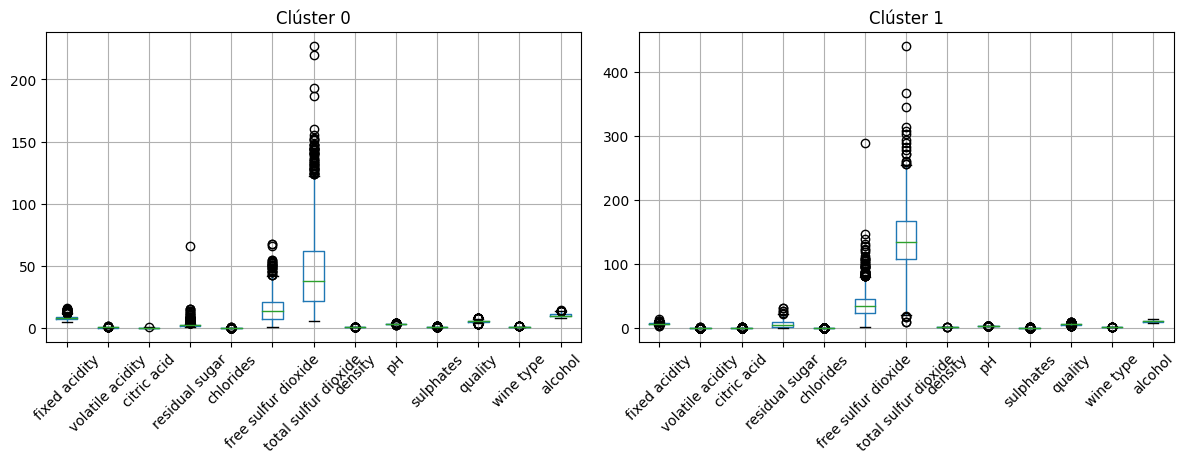

In [9]:
# Realizamos un análisis de varianza (ANOVA)
import scipy.stats as stats

anova_result = stats.f_oneway(*(wine_data[wine_data['cluster'] == cluster]['quality'] for cluster in range(best_k)))
print("ANOVA p-value:", anova_result.pvalue)
# Calculamos los centroides de los clústeres
centroids = kmeans.cluster_centers_
# Comparamos los centroides de los clústeres
centroid_df = pd.DataFrame(centroids, columns = X.columns)
print("Centroides de los clústeres:")
print(centroid_df)
# Visualizamos la distribución de las características dentro de cada clúster
plt.figure(figsize = (12, 8))

for i in range(best_k):
    plt.subplot(2, int(best_k/2)+1, i+1)  # Convertimos best_k/2 a entero
    cluster_data = wine_data[wine_data['cluster'] == i].drop('cluster', axis=1)
    cluster_data.boxplot(rot = 45)
    plt.title(f'Clúster {i}')
plt.tight_layout()
plt.show()

Como podemos observar con k=2 vemos un grupo ligeramente mas decantado por una quality superior ,mientras que otro algo por debajo en este sentido Podemos ver que e Clúster 1 muestra un patrón opuesto, con valores más bajos en las primeras características mencionadas y valores más altos en 'wine type' y 'alcohol'.

Los gráficos de caja también muestran las distribuciones de cada característica dentro de cada clúster, lo que permite identificar diferencias adicionales entre los clústeres.

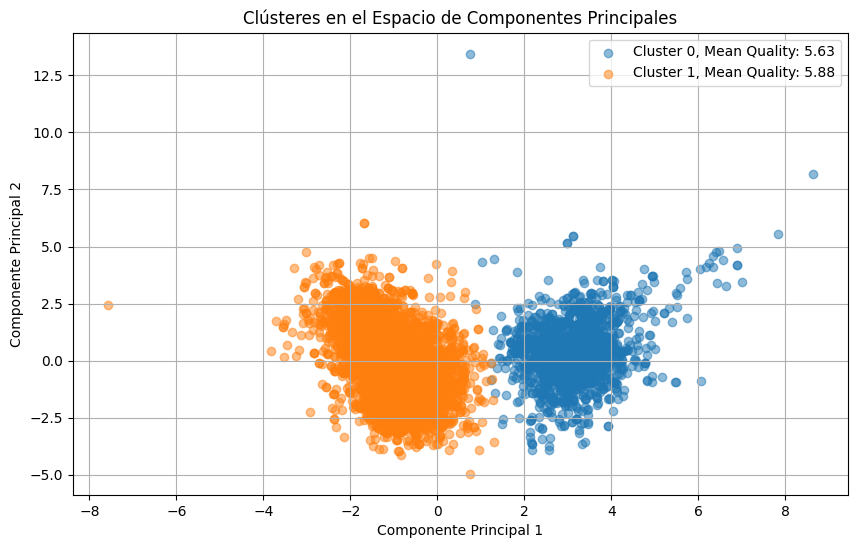

In [10]:
from sklearn.decomposition import PCA

# Reducción de dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Ajuste de K-Means con el mejor valor de k
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
kmeans.fit(X_scaled)

# Agregamos las etiquetas de clúster al DataFrame original
wine_data['cluster'] = kmeans.labels_

# Graficar los clústeres en el espacio de 2 componentes principales
plt.figure(figsize=(10, 6))
for cluster, quality_mean in quality_means.items():
    cluster_data = X_pca[wine_data['cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}, Mean Quality: {quality_mean:.2f}', alpha=0.5)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clústeres en el Espacio de Componentes Principales')
plt.legend()
plt.grid(True)
plt.show()






Al utilizar el método de la silueta, encontramos que 2 clusters obtienen una puntuación de silueta más alta que otros valores de k. Esto significa que para k=2, los datos están mejor agrupados y separados en comparación con otros valores de k.
Sin embargo, al tener un conjunto de datos grande (7000 datos), puede que la puntuación de silueta sea alta para k=2 debido a la cohesión dentro de los clusters, pero no necesariamente significa que sea la mejor opción para representar la estructura real de los datos.


# Selección del mejor k por el teorema del codo

El método del codo busca el punto en el que la disminución en la suma de las distancias cuadradas entre clusters se hace significativamente más lenta, lo que indica que agregar más clusters no proporciona mucha ganancia en términos de cohesión.

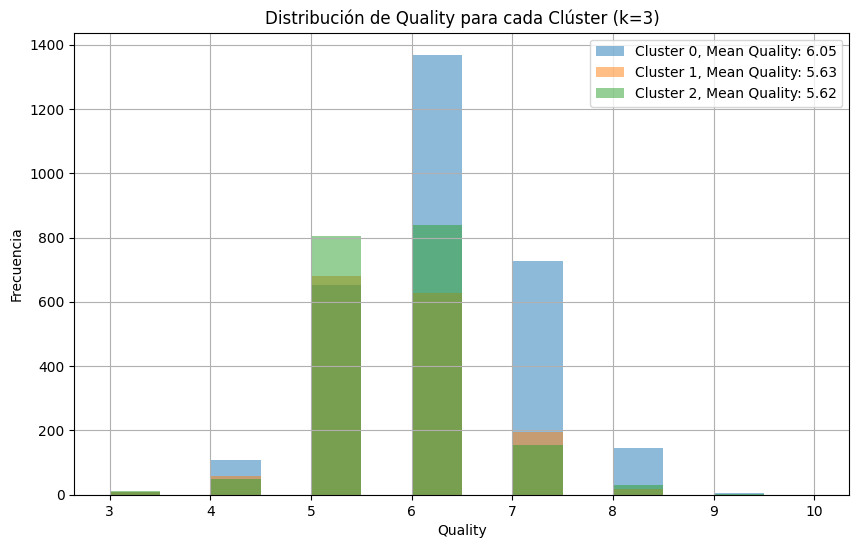

In [17]:
# Aplicamos el algoritmo K-Means con el mejor valor de k
best_k_3 = 3  # El mejor valor de k obtenido
kmeans_3 = KMeans(n_clusters=best_k_3, n_init=10, random_state=42)
kmeans_3.fit(X_scaled)
# Agregamos las etiquetas de clúster al DataFrame original
wine_data_3 = wine_data.copy()
wine_data_3['cluster'] = kmeans_3.labels_
# Calculamos la media de calidad por clúster
quality_means_3 = wine_data_3.groupby('cluster')['quality'].mean()
# Pintamos la distribución de la calidad por clúster
plt.figure(figsize=(10, 6))

for cluster, quality_mean in quality_means_3.items():
    cluster_data = wine_data_3[wine_data_3['cluster'] == cluster]
    plt.hist(cluster_data['quality'], bins=np.arange(3, 10.5, 0.5), alpha=0.5, label=f'Cluster {cluster}, Mean Quality: {quality_mean:.2f}')
plt.xlabel('Quality')
plt.ylabel('Frecuencia')
plt.title('Distribución de Quality para cada Clúster (k=3)')
plt.legend()
plt.grid(True)
plt.show()


En k = 3 observamos que hay una mayor diferencicación de la quality entre los clusters y que sus caracteristicas se ven mas enfentadas.

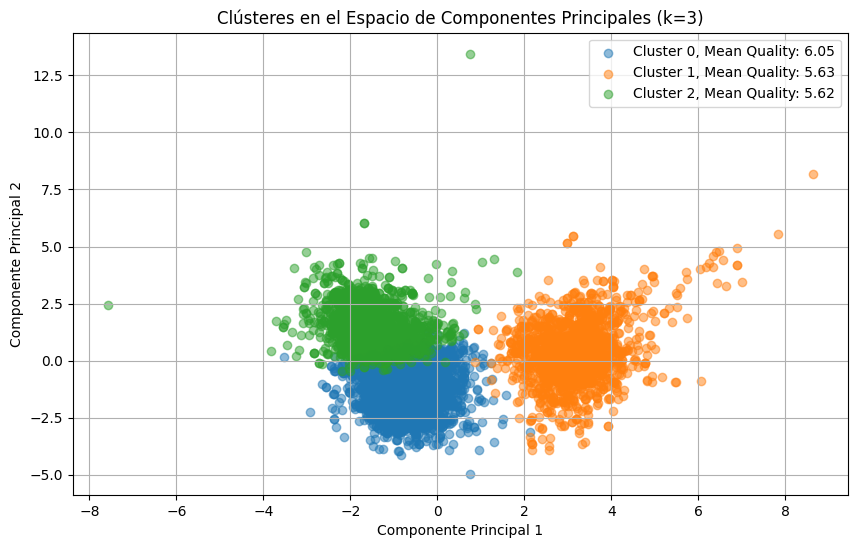

In [12]:
from sklearn.decomposition import PCA

# Reducción de dimensionalidad a 2 componentes principales
pca_3 = PCA(n_components=2)
X_pca_3 = pca_3.fit_transform(X_scaled)

# Graficar los clústeres en el espacio de 2 componentes principales
plt.figure(figsize=(10, 6))
for cluster, quality_mean in quality_means_3.items():
    cluster_data = X_pca_3[wine_data_3['cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}, Mean Quality: {quality_mean:.2f}', alpha=0.5)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clústeres en el Espacio de Componentes Principales (k=3)')
plt.legend()
plt.grid(True)
plt.show()

Al visualizar los clusters utilizando PCA, se observa que con k=3 los datos se separan claramente en tres clusters bien definidos

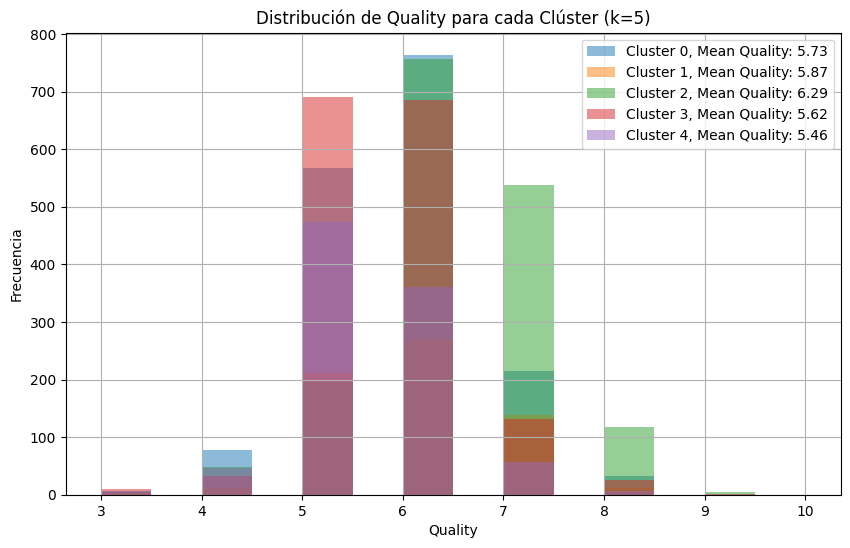

In [13]:
# Aplicamos el algoritmo K-Means con el mejor valor de k
best_k_5 = 5  # El mejor valor de k obtenido
kmeans_5 = KMeans(n_clusters=best_k_5, n_init=10, random_state=42)
kmeans_5.fit(X_scaled)
# Agregamos las etiquetas de clúster al DataFrame original
wine_data_5 = wine_data.copy()
wine_data_5['cluster'] = kmeans_5.labels_
# Calculamos la media de calidad por clúster
quality_means_5 = wine_data_5.groupby('cluster')['quality'].mean()
# Pintamos la distribución de la calidad por clúster
plt.figure(figsize=(10, 6))

for cluster, quality_mean in quality_means_5.items():
    cluster_data = wine_data_5[wine_data_5['cluster'] == cluster]
    plt.hist(cluster_data['quality'], bins=np.arange(3, 10.5, 0.5), alpha=0.5, label=f'Cluster {cluster}, Mean Quality: {quality_mean:.2f}')
plt.xlabel('Quality')
plt.ylabel('Frecuencia')
plt.title('Distribución de Quality para cada Clúster (k=5)')
plt.legend()
plt.grid(True)
plt.show()

Con k= 5 pese a que parecería que se distribuirían de mejor manera se vuleve innecesario el análisis ya que 2 clusters recogen prácticamnete las mismas caracteristicas y solapan demasiado unos con otros.

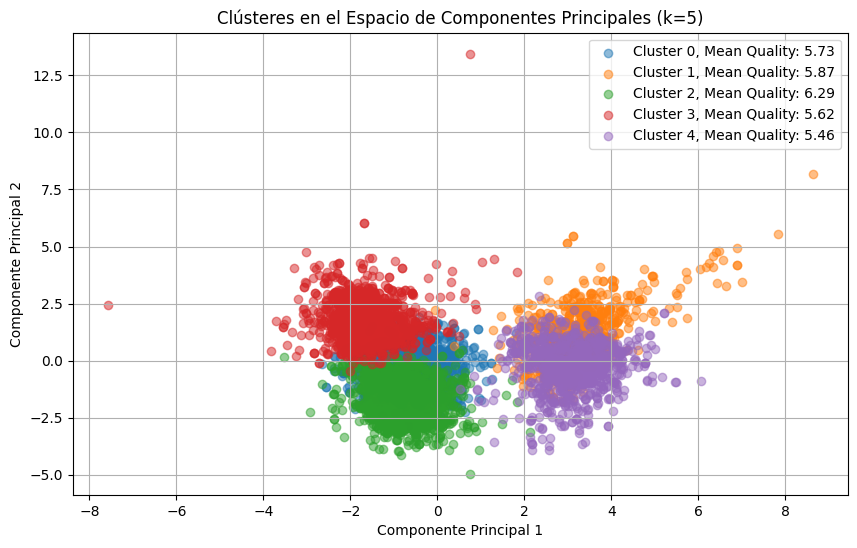

In [14]:
from sklearn.decomposition import PCA

# Reducción de dimensionalidad a 2 componentes principales
pca_5 = PCA(n_components=2)
X_pca_5 = pca_5.fit_transform(X_scaled)

# Graficar los clústeres en el espacio de 2 componentes principales
plt.figure(figsize=(10, 6))
for cluster, quality_mean in quality_means_5.items():
    cluster_data = X_pca_5[wine_data_5['cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}, Mean Quality: {quality_mean:.2f}', alpha=0.5)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clústeres en el Espacio de Componentes Principales (k=5)')
plt.legend()
plt.grid(True)
plt.show()

Al observar los clusters para k=5, se observa que estos se solapan y no estan  claramente separados, lo cual puede ser una señal de que k=3 es una mejor opción.

Elegimos k=3 basándonos en la interpretación visual de los clusters y en la tendencia mostrada por el método del codo, lo que sugiere que k=3 proporciona una mejor representación de la estructura subyacente de los datos.

#Ejercicio	4	(Agrupamiento)

**La empresa productora de vinos desea mejorar el proceso de producción de sus vinos con el objetivo de
mejorar las futuras producciones.
Para ello han pensado en utilizar un algoritmo de agrupamiento jerárquico para segmentar los diferentes vinos
en base a sus componentes, calidad y nivel de alcohol.**

**1) Dado el mejor valor de k del apartado anterior selecciona los 10 ejemplos más representativos de cada
clúster para generar un nuevo dataset y aplicar agrupamiento jerárquico y responder a las siguientes
preguntas: ¿Cuál ha sido tu criterio para seleccionar los ejemplos más representativos de cada clúster?**

Para seleccionar los ejemplos más representativos de cada clúster, utilizaremos el criterio de cercanía al centroide del clúster, empleando medidas de distancia euclidiana. Este enfoque implica calcular la distancia entre cada ejemplo y el centroide del clúster y seleccionar aquellos ejemplos que presenten la distancia más baja al centroide, lo que nos permite hacer representaciones óptimas de las características medias del clúster.

Esta selección se basa en la premisa de que los ejemplos más cercanos al centroide muestran mejor la variabilidad y las características distintivas del clúster, asegurando así una representación adecuada de la diversidad de los datos dentro del clúster.

**2)Seleccionar un algoritmo de agrupamiento jerárquico y generar los diferentes clústeres en base a los
atributos seleccionados (0.75 puntos).**


Seleccionamos el algoritmo de agrupamiento jerárquico aglomerativo, este comienza considerando cada punto de datos como un cluster individual. Luego, en cada paso, une los dos clusters más cercanos según una medida de distancia (en nuestro caso al distancia eulcídea) hasta que todos los puntos de datos estén en un solo cluster. Este proceso forma una jerarquía de clusters, que se puede visualizar en un dendrograma.

Seleccionamos los 10 ejemplos más representativos de cada clúster utilizando la distancia euclidiana entre cada punto de datos y el centroide del clúster. Luego, ordenamos los puntos de datos en función de su distancia al centroide y selecciona los 10 puntos más cercanos como los ejemplos más representativos de cada clúster.

In [15]:
# Calcular los centroides de k=3
centroids_3 = kmeans_3.cluster_centers_

# Seleccionar los ejemplos más representativos de cada clúster
representative_examples = []
for cluster in range(best_k_3):
    cluster_data = wine_data_3[wine_data_3['cluster'] == cluster]
    centroid = centroids_3[cluster]
    distances = np.linalg.norm(X_scaled[wine_data_3['cluster'] == cluster] - centroid, axis=1)  # Distancia euclidiana
    sorted_indices = np.argsort(distances)
    examples = cluster_data.iloc[sorted_indices[:10]]  # Seleccionar los 10 ejemplos más cercanos
    representative_examples.extend(examples.values.tolist())

# Limitar a 10 muestras por cluster
representative_examples = representative_examples[:min(best_k_3 * 10, len(representative_examples))]

# Crear un DataFrame con los ejemplos más representativos de cada clúster
result_df = pd.DataFrame(representative_examples, columns=wine_data_3.columns)

# Imprimir los resultados separados por clúster
for i in range(best_k_3):
    print(f'Individuos más cercanos al clúster {i}:')
    cluster_examples = result_df[result_df['cluster'] == i]
    display(cluster_examples)
    print()

# Aplicar el algoritmo de agrupamiento jerárquico
linkage_matrix = linkage(representative_examples, method='ward')




Individuos más cercanos al clúster 0:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol,cluster
0,6.9,0.32,0.30,1.8,0.036,28.0,117.0,0.99269,3.24,0.48,6.0,2.0,11.0,0.0
1,7.1,0.25,0.28,1.2,0.040,31.0,111.0,0.99174,3.18,0.53,5.0,2.0,11.1,0.0
2,7.0,0.24,0.26,1.7,0.041,31.0,110.0,0.99142,3.20,0.53,6.0,2.0,11.0,0.0
3,7.0,0.29,0.37,4.9,0.034,26.0,127.0,0.99280,3.17,0.44,6.0,2.0,10.8,0.0
4,7.0,0.23,0.35,1.4,0.036,31.0,113.0,0.99120,3.16,0.48,7.0,2.0,10.8,0.0
5,7.2,0.25,0.32,1.5,0.054,24.0,105.0,0.99154,3.17,0.48,6.0,2.0,11.1,0.0
6,6.9,0.31,0.32,1.6,0.036,34.0,114.0,0.99068,3.19,0.45,7.0,2.0,11.4,0.0
7,6.4,0.28,0.28,3.0,0.040,19.0,98.0,0.99216,3.25,0.47,6.0,2.0,11.1,0.0
8,6.4,0.26,0.30,2.2,0.025,33.0,134.0,0.99200,3.21,0.47,6.0,2.0,10.6,0.0
9,6.8,0.24,0.34,5.1,0.038,31.0,99.0,0.99210,3.24,0.46,6.0,2.0,11.8,0.0



Individuos más cercanos al clúster 1:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol,cluster
10,8.3,0.540,0.28,1.9,0.077,11.0,40.0,0.99780,3.39,0.61,6.0,1.0,10.0,1.0
11,8.3,0.610,0.30,2.1,0.084,11.0,50.0,0.99720,3.40,0.61,6.0,1.0,10.2,1.0
12,8.7,0.630,0.28,2.7,0.096,17.0,69.0,0.99734,3.26,0.63,6.0,1.0,10.2,1.0
13,8.0,0.620,0.33,2.7,0.088,16.0,37.0,0.99720,3.31,0.58,6.0,1.0,10.7,1.0
14,8.3,0.430,0.30,3.4,0.079,7.0,34.0,0.99788,3.36,0.61,5.0,1.0,10.5,1.0
15,8.4,0.635,0.36,2.0,0.089,15.0,55.0,0.99745,3.31,0.57,4.0,1.0,10.4,1.0
16,8.7,0.480,0.30,2.8,0.066,10.0,28.0,0.99640,3.33,0.67,7.0,1.0,11.2,1.0
17,7.8,0.500,0.30,1.9,0.075,8.0,22.0,0.99590,3.31,0.56,6.0,1.0,10.4,1.0
18,8.0,0.620,0.35,2.8,0.086,28.0,52.0,0.99700,3.31,0.62,5.0,1.0,10.8,1.0
19,8.2,0.510,0.24,2.0,0.079,16.0,86.0,0.99764,3.34,0.64,6.0,1.0,9.5,1.0



Individuos más cercanos al clúster 2:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol,cluster
20,6.8,0.24,0.38,8.3,0.045,50.0,185.0,0.99578,3.15,0.50,6.0,2.0,9.5,2.0
21,6.8,0.27,0.37,8.2,0.055,52.0,192.0,0.99586,3.11,0.52,6.0,2.0,9.5,2.0
22,7.2,0.30,0.30,8.1,0.050,40.0,188.0,0.99652,3.15,0.49,6.0,2.0,9.1,2.0
23,6.3,0.25,0.44,11.6,0.041,48.0,195.0,0.99680,3.18,0.52,5.0,2.0,9.5,2.0
24,7.2,0.28,0.26,12.5,0.046,48.0,179.0,0.99750,3.10,0.52,6.0,2.0,9.0,2.0
25,6.8,0.26,0.40,7.5,0.046,45.0,179.0,0.99583,3.20,0.49,5.0,2.0,9.3,2.0
26,6.5,0.25,0.32,9.9,0.045,41.0,128.0,0.99636,3.18,0.52,6.0,2.0,9.6,2.0
27,7.4,0.38,0.34,8.3,0.052,44.0,168.0,0.99627,3.11,0.52,5.0,2.0,9.2,2.0
28,7.4,0.38,0.34,8.3,0.052,44.0,168.0,0.99627,3.11,0.52,5.0,2.0,9.2,2.0
29,6.6,0.23,0.37,8.5,0.036,46.0,153.0,0.99576,3.20,0.48,6.0,2.0,9.4,2.0


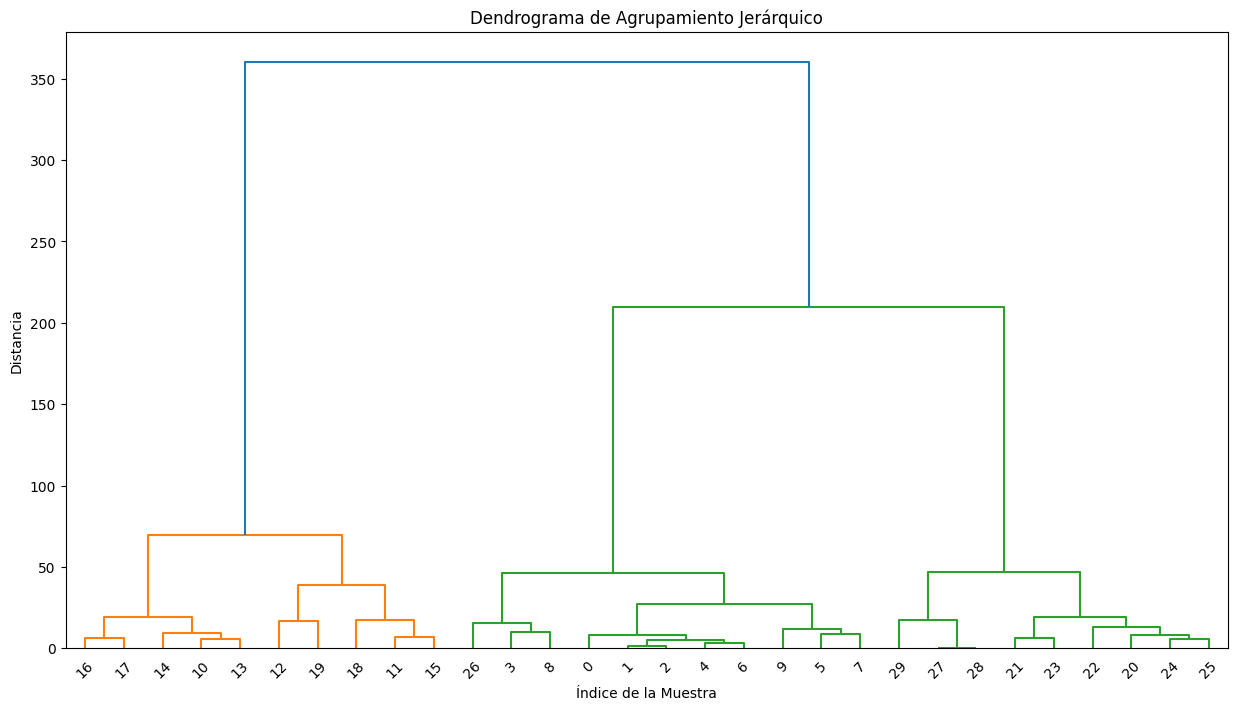

In [16]:
# Generar el dendrograma
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix)
plt.title('Dendrograma de Agrupamiento Jerárquico')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Distancia')
plt.show()


Al generar el dendrograma con estos datos, observamos una estructura clara que indica la presencia de tres clusters distintos.

Al comparar el dendrograma del clustering jerárquico aglomerativo con los clusters obtenidos por K-Means, observamos una correspondencia entre la estructura del dendrograma y los clusters definidos por K-Mean.
La correspondencia entre los clusters definidos por K-Means y la estructura del dendrograma del clustering jerárquico aglomerativo indica que la selección de los ejemplos representativos fue efectiva para capturar la estructura de los datos.

